## Задача 1 (10 pts)

Пусть задан набор из $N$ пар точек в $n$-мерном пространстве $x_1, \ldots , x_N$ и $y_1, \ldots, y_N$.
Также даны расстояния $d_1, \ldots , d_N$ между ними. Необходимо найти такую матрицу $M \in \mathbb{S}^n_+$, что 
$d_i \approx d(x_i, y_i) = \sqrt{(x_i − y_i)M(x_i − y_i)}$. 
Таким образом, целевой функцией в
данной задаче является следующая функция
$$ 
\min_{M \in \mathbb{S}^n_+} \frac{1}{N}\sum_{i=1}^N (d_i - d(x_i, y_i))^2.
$$

В данном случае при старте из точки $M_0 \in \mathbb{S}^n_+$ тестируемые методы не должен выводить промежуточные точки $M_k$ за границы допустимого множества, но не забудьте это проверять и модифицируйте размер шага соответственно.

Сравните сходимость градиентного спуска, метода тяжёлого шарика и быстрого градиентного метода для решения этой задачи. Нарисуйте графики сходимости для каждого метода.

Также проверьте ошибку на тестовых данных ```d_test, X_test, Y_test```. Прокомментируйте результат.

### Решение

Обозначим $z_i = x_i - y_i,\;d(z_i) = \sqrt{z_i^\top M z_i},\; f(M)=\dfrac{1}{N}\sum\limits_{i=1}^N (d_i - d(x_i, y_i))^2$.

Выпишем градиент функции $\dfrac{\partial f(M)}{\partial M}$:

$
\dfrac{\partial d(z_i)}{\partial M} = \dfrac{1}{2d(z_i)}z_i z_i^\top 
$

$
\dfrac{\partial f(M)}{\partial M} = \dfrac{1}{N}\sum\limits_{i=1}^N \dfrac{\partial}{\partial M}(d_i - d(z_i))^2 = 
\dfrac{1}{N}\sum\limits_{i=1}^N \dfrac{d_i - d(z_i)}{d(z_i)}z_i z_i^\top.
$

Выберем начальное приближение $M_0 = I$. Важно заметить, что градиентные шаги сохраняют симметричность $M_k$, так как $\dfrac{\partial f(M)}{\partial M} \in \mathbb{S}^n$. 


Для учета условия $M \in \mathbb{S}^n_+$ используем два разных подхода:

1. Будем использовать метод проекции градиента. На лекции было показано, что для $C=\mathbb{S}^n_+$ проекцией является:

    $
    \pi_C(X) = \sum\limits_{i=1}^n \max(0,\lambda_i) q_i q_i^\top
    $, где $X = \sum\limits_{i=1}^n \lambda_i q_i q_i^\top$ &mdash; разложение по собственным векторам.

    После каждого градиентного шага будем проецировать очередное значение $M_k$ на $\mathbb{S}^n_+$.
2. Перед шагом будем проверять условие $M \in \mathbb{S}^n_+$, в случае его нарушения уменьшим градиентный шаг в два раза (`lr /= 2`). После шага восстановим `lr` к исходной величине для следующих итераций. Для метода тяжелого шарика при сильном уменьшении `lr` будем переходить к обычному градинетному методу на этом шаге, для быстрого градиентного метода - будем делать обычный градиентный шаг на данном шаге и перезапускать метод.

Реализуем 4 метода оптимизации первого порядка: метод градиентного спуска `gd`, метод тяжёлого шарика `heavy_ball` и быстрый градиентный метод `acc_gd` (с перезапусками `restart=True` и без).

In [1]:
from scipy import linalg as la
import numpy as np
np.random.seed(8)

n = 5 # Dimension
N = 100 # Number of sample
N_test = 10 # Samples for test set

X = np.random.randn(n,N)
Y = np.random.randn(n,N)

X_test = np.random.randn(n,N_test)
Y_test = np.random.randn(n,N_test)

P = np.random.randn(n,n)
P = P.dot(P.T) + np.identity(n)
sqrtP = la.sqrtm(P)

d = np.linalg.norm(sqrtP.dot(X-Y),axis=0)
# it's better to reduce noise in d, it severely impacts the resultant loss
noise_sigma = 1.
d = np.maximum(d + np.random.randn(N) * noise_sigma, 0)
d_test = np.linalg.norm(sqrtP.dot(X_test-Y_test),axis=0)
d_test = np.maximum(d_test + np.random.randn(N_test) * noise_sigma, 0)

In [2]:
import matplotlib.pyplot as plt
import typing as tp
plt.rcParams.update({'text.usetex' : True})

Z = X - Y 
M_0 = np.identity(n)

In [3]:
def proj_PSD(M: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    L, Q = np.linalg.eigh(M)
    L_plus = np.clip(L, a_min=eps, a_max=None)
    return np.einsum('ik,k,kj->ij', Q, L_plus, Q.T)

def is_PSD(M: np.ndarray, eps: float = 1e-8) -> bool:
    L = np.linalg.eigvalsh(M)
    return np.all(L >= eps)

def loss_M(M: np.ndarray, Z: np.ndarray, d: np.ndarray) -> np.ndarray:
    residuals = d - np.sqrt(np.einsum('ib,ij,jb->b', Z, M, Z))
    value = np.mean(residuals**2)
    
    return value

def grad_M(
        M: np.ndarray, 
        Z: np.ndarray,
        d: np.ndarray,
        eps: float = 1e-12
    ) -> np.ndarray:
    g = np.zeros_like(M)
    for i in range(Z.shape[1]):
        z = Z[:, i]
        dist = np.sqrt(z.T @ M @ z)
        
        g += (dist - d[i]) / (dist + eps) * np.outer(z, z)
        
    g /= Z.shape[1]
    
    return g

In [ ]:
def gd(
        grad: tp.Callable[[np.ndarray], np.ndarray],
        loss: tp.Callable[[np.ndarray], np.ndarray], 
        x_0: np.ndarray,
        lr: float,
        max_iter: int = 1000, 
        tol: float = 0.,
        lr_cond: tp.Optional[tp.Callable[[np.ndarray], np.ndarray]] = None,
        proj: tp.Optional[tp.Callable[[np.ndarray], np.ndarray]] = None,
    ) -> tuple[np.ndarray, list[float], list[float]]:
    if lr_cond is not None and proj is not None:
        raise ValueError("lr_cond and proj cannot be used at the same time")
    
    loss_log = []
    grad_norm_log = []
    lr_factor = 1.
    
    x = x_0.copy()
    
    for it in range(max_iter):
        g = grad(x)
        
        # lr reduction while `lr_cond` is not satisfied (is used) 
        if lr_cond is not None:
            while not lr_cond(x - lr * lr_factor * g):
                lr_factor /= 2
                
            x -= lr * lr_factor * g
            
            lr_factor = 1.
        else:
            x -= lr * g
            
            # gradinent projection (if used)
            if proj is not None:
                x = proj(x)
        
        loss_log.append(loss(x).copy())
        grad_norm_log.append(la.norm(g))
        
        if grad_norm_log[-1] < tol:
            break

    return x, loss_log, grad_norm_log


def heavy_ball(
        grad: tp.Callable[[np.ndarray], np.ndarray],
        loss: tp.Callable[[np.ndarray], np.ndarray], 
        x_0: np.ndarray, 
        lr: float,
        beta: float,
        max_iter: int = 1000, 
        tol: float = 0., 
        lr_cond: tp.Optional[tp.Callable[[np.ndarray], np.ndarray]] = None,
        proj: tp.Callable[[np.ndarray], np.ndarray] = None
) -> tuple[np.ndarray, list[float], list[float]]:
    if lr_cond is not None and proj is not None:
        raise ValueError("lr_cond and proj cannot be used at the same time")
    
    loss_log = []
    grad_log = []
    lr_factor = 1.
    # beta_factor is either 0. or 1., beta_factor is set to 0. in case lr_factor becomes rather small
    beta_factor = 1.
    
    x = x_0.copy()
    x_prev = x.copy()
    
    for it in range(max_iter):
        g = grad(x)
        
        if lr_cond is not None:
            while not lr_cond(x - lr * lr_factor * g  + beta * beta_factor * (x - x_prev)):
                lr_factor /= 2
                # remove inertia if lr_factor is small
                if lr_factor < 1e-4:
                    beta_factor = 0.
                    
            x_new = x - lr * lr_factor * g  + beta * beta_factor * (x - x_prev)
            
            lr_factor = 1. 
            beta_factor = 1.  
        else:
            x_new = x - lr * g  + beta * (x - x_prev)
            # gradinent projection (if used)
            if proj is not None:
                x_new = proj(x_new)
        
        x_prev = x.copy()
        x = x_new.copy()
        
        loss_log.append(loss(x))
        grad_log.append(la.norm(g))
        
        if grad_log[-1] < tol:
            break

    return x, loss_log, grad_log

def acc_gd(
    grad: tp.Callable[[np.ndarray], np.ndarray],
    loss: tp.Callable[[np.ndarray], np.ndarray], 
    x_0: np.ndarray, 
    lr: float,
    restart: bool = False,
    max_iter: int = 1000, 
    tol: float = 0., 
    lr_cond: tp.Optional[tp.Callable[[np.ndarray], np.ndarray]] = None,
    proj: tp.Callable[[np.ndarray], np.ndarray] = None
) -> tuple[np.ndarray, list[float], list[float]]:
    if lr_cond is not None and proj is not None:
        raise ValueError("lr_cond and proj cannot be used at the same time")
    if lr_cond is not None and restart:
        raise ValueError("restart is not implemented for lr_cond")
    
    loss_log = []
    grad_log = []
    lr_factor = 1.
    
    # in case lr becomes rather small, use simple gd
    lr_gd_fallback = False
    
    x = x_0.copy()
    y = x_0.copy()
    
    k = 1
    for it in range(max_iter):
        # lr reduction while `lr_cond` is not satisfied (is used) 
        if lr_cond is not None:
            while ((not lr_gd_fallback) and (not lr_cond(y - lr * lr_factor * grad(y)))) or \
                  ((not lr_gd_fallback) and (not lr_cond(x - lr * grad(x)))):
                lr_factor /= 2
                if lr_factor < 1e-4:
                    lr_gd_fallback = True
            
            if not lr_gd_fallback:
                x_next = y - lr * lr_factor * grad(y)
            else:
                x_next = x - lr * grad(x)
                k = 1
                
            y = x_next + k / (k + 3) * (x_next - x)
            x = x_next.copy()
            
            k += 1
            
            lr_factor = 1.
            lr_gd_fallback = False
        else:
            x_next = y - lr * grad(y)
            
            # restart (if used)
            if restart and loss(x) < loss(x_next):
                x_next = x - lr * grad(x)
                k = 1
                
            # gradinent projection (if used)            
            if proj is not None:
                x_next = proj(x_next)
        
            y = x_next + k / (k + 3) * (x_next - x)
            x = x_next.copy()
            
            k += 1
        
        g = grad(x)
        loss_log.append(loss(x))
        grad_log.append(la.norm(g))
        
        if np.linalg.norm(g) < tol:
            break
        
    return x, loss_log, grad_log
         

* Проведем эксперименты с проекцией градиента:

In [5]:
M_proj_gd, loss_proj_gd, grad_proj_gd = gd(
    grad=lambda x: grad_M(x, Z=Z, d=d),
    proj=proj_PSD,
    loss=lambda x: loss_M(x, Z=Z, d=d),
    x_0=M_0,
    lr=1,
    max_iter=300,
    tol=0.
)

M_proj_hb, loss_proj_hb, grad_proj_hb = heavy_ball(
    grad=lambda x: grad_M(x, Z=Z, d=d),
    proj=proj_PSD,
    loss=lambda x: loss_M(x, Z=Z, d=d),
    x_0=M_0,
    lr=1,
    beta=0.5,
    max_iter=300,
    tol=0.
)

M_proj_accgd, loss_proj_accgd, grad_proj_accgd = acc_gd(
    grad=lambda x: grad_M(x, Z=Z, d=d),
    proj=proj_PSD,
    loss=lambda x: loss_M(x, Z=Z, d=d),
    x_0=M_0,
    lr=1,
    restart=False,  # without restarts
    max_iter=300,
    tol=0.
)

M_proj_accgd_restarts, loss_proj_accgd_restarts, grad_proj_accgd_restarts = acc_gd(
    grad=lambda x: grad_M(x, Z=Z, d=d),
    proj=proj_PSD,
    loss=lambda x: loss_M(x, Z=Z, d=d),
    x_0=M_0,
    lr=1,
    restart=True,  # with restarts
    max_iter=300,
    tol=0.
)

Дополнительно проверим, что полученные матрицы являются симметричными и неотрицательно определенными:

In [6]:
M_proj_results = {
    'GD' : M_proj_gd, 
    'HB': M_proj_hb, 
    'AccGD' : M_proj_accgd,
    'AccGDr' : M_proj_accgd_restarts
}

for name, M_curr in M_proj_results.items():
    print(f'{name:6}: Is symmetric={np.allclose(M_curr, M_curr.T)}; Is PSD={np.all(la.eigvals(M_curr) > 0)}')
    

GD    : Is symmetric=True; Is PSD=True
HB    : Is symmetric=True; Is PSD=True
AccGD : Is symmetric=True; Is PSD=True
AccGDr: Is symmetric=True; Is PSD=True


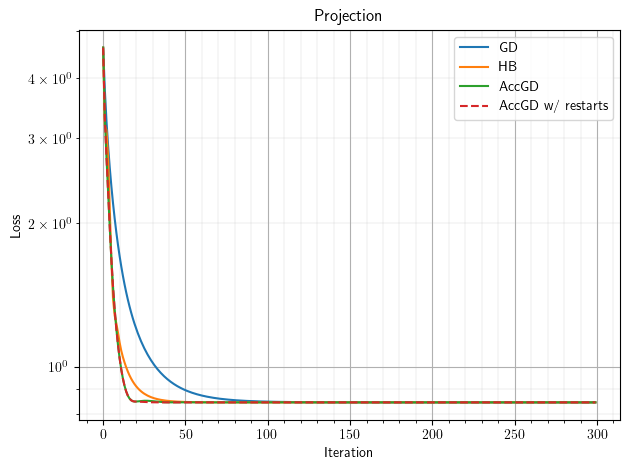

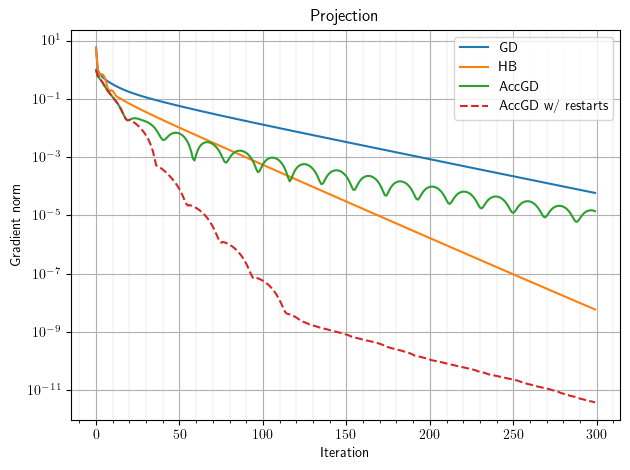

In [7]:
plt.figure()
plt.title("Projection")
plt.semilogy(loss_proj_gd, label='GD')
plt.semilogy(loss_proj_hb, label='HB')
plt.semilogy(loss_proj_accgd, label='AccGD')
plt.semilogy(loss_proj_accgd_restarts, label='AccGD w/ restarts', ls='--')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.minorticks_on()
plt.grid(True, which='major'); plt.grid(True, which='minor', lw=0.3, alpha=0.5)
plt.tight_layout()

plt.figure()
plt.title("Projection")
plt.semilogy(grad_proj_gd, label='GD')
plt.semilogy(grad_proj_hb, label='HB')
plt.semilogy(grad_proj_accgd, label='AccGD')
plt.semilogy(grad_proj_accgd_restarts, label='AccGD w/ restarts', ls='--')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Gradient norm')
plt.minorticks_on()
plt.grid(True, which='major'); plt.grid(True, which='minor', lw=0.3, alpha=0.5)
plt.tight_layout()

Можно видеть, что все методы сходтся к близким значениям оптимизируемой функции. Самым быстрым методом оказался ускоренный градиентный метод с перезапусками, за ним - ускоренный градиентный метод, далее метод тяжелого шарика и обычный градиентный спуск. При этом вблизи оптимума метод тяжелого шарика обогнал обычный ускоренный градиентный метод. С хорошей точностью полученные матрицы $M$ близки к друг другу и к искомой матрице (сравнение по относительной ошибке в норме Фробениуса):

In [8]:
for name, M_curr in M_proj_results.items():
    print(f'{name:6}: error={np.linalg.norm(M_curr - P) / np.linalg.norm(P):.8f}')

GD    : error=0.12841401
HB    : error=0.12837899
AccGD : error=0.12837186
AccGDr: error=0.12837899


На тестовой выборке значение оптимимзируемой функции близко к значению на обучающкй выборке. Различие связано, в первую очередь, с высоким уровнем шума в $d$. При запусках с другими seed'ами значение в оптимуме на тесте и обучении может несколько варьироваться, особенно принимая во внимание малый размер выборки.

In [9]:
for name, M_curr in M_proj_results.items():
    print(f'{name:6}: train={loss_M(M_curr, X - Y, d):.5g}; test={loss_M(M_curr, X_test - Y_test, d_test):.5g}')

GD    : train=0.84588; test=0.82317
HB    : train=0.84588; test=0.8235
AccGD : train=0.84588; test=0.82356
AccGDr: train=0.84588; test=0.8235


* Повторим эксперимент для первых трех методов с использованием другого подхода: уменьшения градинетного шага при условии $M_k \notin \mathbb{S}^n_+$. В данном эксперименте не рассматривается ускоренный метод с перезапуском (перезапуск происходит только при попытках уменьшить `lr` при выходе из $\mathbb{S}^n_+$, а не при увеличении оптимизируемой функции)

In [10]:
M_lr_cond_gd, loss_lr_cond_gd, grad_lr_cond_gd = gd(
    grad=lambda x: grad_M(x, Z=Z, d=d),
    lr_cond=is_PSD,
    loss=lambda x: loss_M(x, Z=Z, d=d),
    x_0=M_0,
    lr=1,
    max_iter=300,
    tol=0.
)

M_lr_cond_hb, loss_lr_cond_hb, grad_lr_cond_hb = heavy_ball(
    grad=lambda x: grad_M(x, Z=Z, d=d),
    lr_cond=is_PSD,
    loss=lambda x: loss_M(x, Z=Z, d=d),
    x_0=M_0,
    lr=1,
    beta=0.5,
    max_iter=300,
    tol=0.
)

M_lr_cond_accgd, loss_lr_cond_accgd, grad_lr_cond_accgd = acc_gd(
    grad=lambda x: grad_M(x, Z=Z, d=d),
    lr_cond=is_PSD,
    loss=lambda x: loss_M(x, Z=Z, d=d),
    x_0=M_0,
    lr=1,
    restart=False,
    max_iter=300,
    tol=0.
)

In [11]:
M_lr_cond_results = {
    'GD' : M_lr_cond_gd, 
    'HB': M_lr_cond_hb, 
    'AccGD' : M_lr_cond_accgd,
}

for name, M_curr in M_lr_cond_results.items():
    print(f'{name:6}: Is symmetric={np.allclose(M_curr, M_curr.T)}; Is PSD={np.all(la.eigvals(M_curr) > 0)}')

GD    : Is symmetric=True; Is PSD=True
HB    : Is symmetric=True; Is PSD=True
AccGD : Is symmetric=True; Is PSD=True


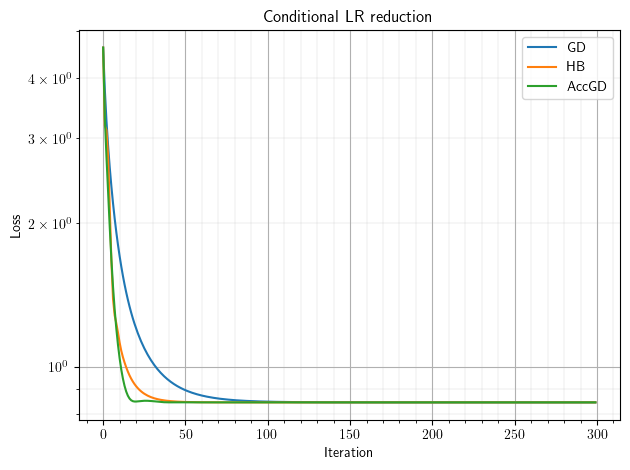

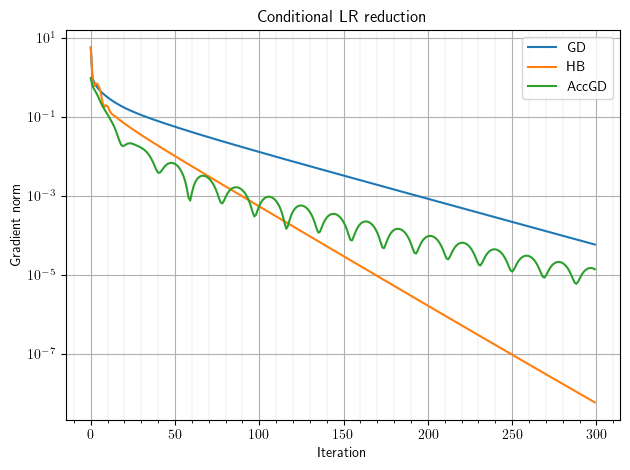

In [12]:
plt.figure()
plt.title("Conditional LR reduction")
plt.semilogy(loss_lr_cond_gd, label='GD')
plt.semilogy(loss_lr_cond_hb, label='HB')
plt.semilogy(loss_lr_cond_accgd, label='AccGD')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.minorticks_on()
plt.grid(True, which='major'); plt.grid(True, which='minor', lw=0.3, alpha=0.5)
plt.tight_layout()

plt.figure()
plt.title("Conditional LR reduction")
plt.semilogy(grad_lr_cond_gd, label='GD')
plt.semilogy(grad_lr_cond_hb, label='HB')
plt.semilogy(grad_lr_cond_accgd, label='AccGD')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Gradient norm')
plt.minorticks_on()
plt.grid(True, which='major'); plt.grid(True, which='minor', lw=0.3, alpha=0.5)
plt.tight_layout()

In [13]:
for name, M_curr in M_lr_cond_results.items():
    print(f'{name:6}: error={np.linalg.norm(M_curr - P) / np.linalg.norm(P):.8f}')

GD    : error=0.12841401
HB    : error=0.12837899
AccGD : error=0.12837186


Как и в подходе с проекцией градиента, на тестовой выборке значение оптимимзируемой функции близко к значению на обучающкй выборке, с теми же оговорками:

In [14]:
for name, M_curr in M_lr_cond_results.items():
    print(f'{name:6}: train={loss_M(M_curr, X - Y, d):.5g}; test={loss_M(M_curr, X_test - Y_test, d_test):.5g}')

GD    : train=0.84588; test=0.82317
HB    : train=0.84588; test=0.8235
AccGD : train=0.84588; test=0.82356


Получаем, что оба подхода к учету условия $M_k \in \mathbb{S}^n_+$ позвояляют решить задачу, дают близкое качество на обучающей и тестовой выборке, даже при условии сильного зашумления $d$ и ограниченной выборки

* Дополнение: как было указано выше, на результат сильно влияет уровень шума в $d$, при условии ограниченной обучающей выборки качество быстро упирается в шум данных. Попробуем уменьшить его и воспользуемся методом оптимизации с контролем шага (2). Здесь все методы сходятся до значительно более низкого уровня ошибки:

In [15]:
np.random.seed(8)

X = np.random.randn(n,N)
Y = np.random.randn(n,N)

X_test = np.random.randn(n,N_test)
Y_test = np.random.randn(n,N_test)

P = np.random.randn(n,n)
P = P.dot(P.T) + np.identity(n)
sqrtP = la.sqrtm(P)

d = np.linalg.norm(sqrtP.dot(X-Y),axis=0)
# it's better to reduce noise in d, it severely impacts the resultant loss
noise_sigma = 1e-3
d = np.maximum(d + np.random.randn(N) * noise_sigma, 0)
d_test = np.linalg.norm(sqrtP.dot(X_test-Y_test),axis=0)
d_test = np.maximum(d_test + np.random.randn(N_test) * noise_sigma, 0)

In [16]:
M_lr_cond_gd, loss_lr_cond_gd, grad_lr_cond_gd = gd(
    grad=lambda x: grad_M(x, Z=Z, d=d),
    lr_cond=is_PSD,
    loss=lambda x: loss_M(x, Z=Z, d=d),
    x_0=M_0,
    lr=1,
    max_iter=1000,
    tol=0.
)

M_lr_cond_hb, loss_lr_cond_hb, grad_lr_cond_hb = heavy_ball(
    grad=lambda x: grad_M(x, Z=Z, d=d),
    lr_cond=is_PSD,
    loss=lambda x: loss_M(x, Z=Z, d=d),
    x_0=M_0,
    lr=1,
    beta=0.5,
    max_iter=1000,
    tol=0.
)

M_lr_cond_accgd, loss_lr_cond_accgd, grad_lr_cond_accgd = acc_gd(
    grad=lambda x: grad_M(x, Z=Z, d=d),
    lr_cond=is_PSD,
    loss=lambda x: loss_M(x, Z=Z, d=d),
    x_0=M_0,
    lr=1,
    restart=False,
    max_iter=1000,
    tol=0.
)

In [17]:
M_lr_cond_results = {
    'GD' : M_lr_cond_gd, 
    'HB': M_lr_cond_hb, 
    'AccGD' : M_lr_cond_accgd,
}

for name, M_curr in M_lr_cond_results.items():
    print(f'{name:6}: Is symmetric={np.allclose(M_curr, M_curr.T)}; Is PSD={np.all(la.eigvals(M_curr) > 0)}')

GD    : Is symmetric=True; Is PSD=True
HB    : Is symmetric=True; Is PSD=True
AccGD : Is symmetric=True; Is PSD=True


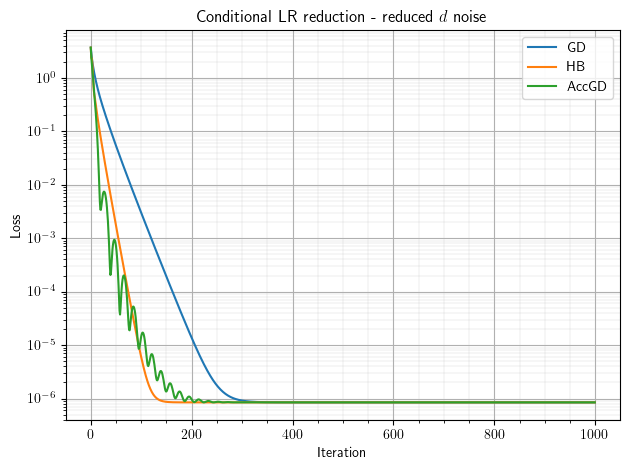

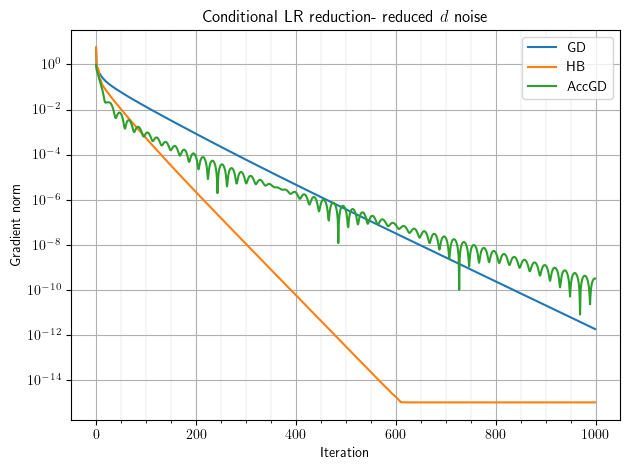

In [18]:
plt.figure()
plt.title("Conditional LR reduction - reduced $d$ noise")
plt.semilogy(loss_lr_cond_gd, label='GD')
plt.semilogy(loss_lr_cond_hb, label='HB')
plt.semilogy(loss_lr_cond_accgd, label='AccGD')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.minorticks_on()
plt.grid(True, which='major'); plt.grid(True, which='minor', lw=0.3, alpha=0.5)
plt.tight_layout()

plt.figure()
plt.title("Conditional LR reduction- reduced $d$ noise")
plt.semilogy(grad_lr_cond_gd, label='GD')
plt.semilogy(grad_lr_cond_hb, label='HB')
plt.semilogy(grad_lr_cond_accgd, label='AccGD')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Gradient norm')
plt.minorticks_on()
plt.grid(True, which='major'); plt.grid(True, which='minor', lw=0.3, alpha=0.5)
plt.tight_layout()

In [19]:
for name, M_curr in M_lr_cond_results.items():
    print(f'{name:6}: error={np.linalg.norm(M_curr - P) / np.linalg.norm(P):.8f}')

GD    : error=0.00012356
HB    : error=0.00012356
AccGD : error=0.00012355


In [20]:
for name, M_curr in M_lr_cond_results.items():
    print(f'{name:6}: train={loss_M(M_curr, X - Y, d):.5g}; test={loss_M(M_curr, X_test - Y_test, d_test):.5g}')

GD    : train=8.4689e-07; test=8.1849e-07
HB    : train=8.4689e-07; test=8.1849e-07
AccGD : train=8.4689e-07; test=8.185e-07


## Задача 2 (10 pts)

- (2 pts) Покажите, что градиенты, полученные на двух последовательных шагах градиентного спуска с использованием правила наискорейшего спуска, ортогональны.

- (5 pts) Докажите, что если целевая функция $f(x) = \frac{1}{2}x^{\top}Qx - b^{\top}x$, $Q \in \mathbb{S}^n_{++}$, шаг определяется с помощью наискорейшего спуска и $x^0 - x^*$ параллелен собственному вектору матрицу $Q$, то градиентный спуск сходится за один шаг. Наискорейший спуск - это метод выбора шага такой что $\alpha^* = \arg\min_{\alpha} f(x_k + \alpha h_k)$

- Покажите, что для $f(x) = x^{\top}x$ градиентный спуск с выбором шага по правилу наискорейшего спуска сходится за одну итерацию:
    - (1 pts) с использованием предыдущего утверждения
    - (2 pts) прямым вычислением 

### Решение
1. Рассмотрим градиентный спуск с использованием правила наискорейшего спуска. На каждом шаге $k$ оптимизируется длина шага $\alpha_k$ в направлении градиента, которая минимизирует функцию $f$ вдоль этого направления. Иными словами:

    $
    x_{k+1} = x_k - \alpha_k \nabla f(x_k),\quad \alpha_k = \argmin\limits_\alpha f(x_k - \alpha \nabla f(x_k))
    $

    Запишем необходимое условие минимума по $\alpha$ на шаге $k$:
    
    $\begin{aligned}
    &\dfrac{d}{d\alpha} f(x_k - \alpha \nabla f(x_k))|_{\alpha=\alpha_k} = 0;\\
    &\dfrac{d}{d\alpha} f(x_k - \alpha \nabla f(x_k)) = \left(\nabla f(x_k - \alpha \nabla f(x_k))\right)^\top \left( -\nabla f(x_k)\right);\\
    &\dfrac{d}{d\alpha} f(x_k - \alpha_k \nabla f(x_k)) = \left(\nabla f(x_{k+1})\right)^\top \left( -\nabla f(x_k)\right) = 0.
    \end{aligned}$

    Получили, что $\left(\nabla f(x_{k+1})\right)^\top \nabla f(x_k) = 0$, то есть при использовании правила наискорейшего спуска градиенты на двух последовательных шагах всегда ортогональны.

2. $f(x)$ &mdash; выпуклая функция $(Q \in \mathbb{S}^n_{++})$, минимум достигается в точке $x^* = Q^{-1}b$, так как $\nabla f(x^*) = Qx^* - b=0$.

    По условию $(x_0 - x^*) || u$, где $u$ &mdash; с.в. $Q$, соответствующий с.з. $\lambda > 0$, то есть $Qu = \lambda u$, коэффициент пропорциональности между векторами обозначим $\mu$: $x_0 - x = \mu u$.

    $h_0 = \nabla f(x_0) = Q x_0 - b = Q(x_0 - Q^{-1}b) = Q(x_0 - x^*) = Q\mu u = \lambda \mu u$, получаем, что $h_0 || u$.

    $\begin{aligned}
    f(x_0 - \alpha h_0)& = \frac{1}{2} (x_0 - \alpha h_0)^\top Q (x_0 - \alpha h_0) - b^\top (x_0 - \alpha h_0) \\  
                       & = \frac{1}{2} h_0^\top Q h_0 \cdot \alpha^2 - (x_0^\top Q h_0 - b^\top h_0) \cdot \alpha + \frac{1}{2}x_0^\top Q x_0 - b^\top x_0.
    \end{aligned}$

    Запишем условие оптимальности длины шага:

    $\begin{aligned}
    &\dfrac{d}{d\alpha}f(x_0 - \alpha h_0)|_{\alpha=\alpha_0} = h_0^\top Q h_0 \alpha_0 - (x_0^\top Q h_0 - b^\top h_0) = 0;\\
    &\alpha_0 = \frac{(Q x_0 - b)^\top h_0}{h_0^\top Q h_0} = \frac{h_0^\top h_0}{h_0^\top Q h_0} = 
    \frac{\lambda^2 \mu^2 u^\top u}{\lambda^3 \mu^2 u^\top u} = \frac{1}{\lambda}.
    \end{aligned}$

    Теперь можем записать обновление шага на первой итерации:

    $
    x_1 = x_0 - \alpha_0 h_0 = x_0 - \dfrac{1}{\lambda}\lambda\mu u = x_0 - \mu u = x_0 - (x_0 - x^*) = x^*.
    $

    Таким образом, $x_1 = x^*$, то есть градиентный спуск сходится за один шаг.

3. Покажем, что для $f(x) = x^{\top}x$ градиентный спуск с выбором шага по правилу наискорейшего спуска сходится за одну итерацию двумя способами:

    1. Утверждение непосредственно следует из предыдущего пункта для $Q=2I,\; b=0$. Минимум достигается в $x^\top = 0 $, $h_0 = 2 x_0$. 
        У матрицы $Q$ cобственные значения равны $\lambda_i = 2$, собственные векторы $u_i = e_i$, то есть собственные векторы образуют канонический базис. Любой вектор $(x_0 - x^*) = x_0$ может быть разложен по базису из $u_i$, то есть будет являться собственным для $Q$ c собственным значением 2: $Qx_0=2Ix_0=2x_0$, то есть $\lambda=2$. Таким образом, $\alpha_0 = 1/\lambda=0.5$. 

        Для любой начальной точки получаем: $x_1=x_0-\alpha_0 h_0 = x_0 - \frac{1}{2} 2x_0 = 0 = x^*$, что и требовалось.

    2. Докажем утверждение напрямую. Выберем произвольную начальную точку $x_0$. Градиент на первом шаге равен $h_0 = 2 x_0$. По доказанному выше в (2) и испольуя сведение к квадратичной задаче (3.1), но не используя факты про собственные значения, получаем:
        
        $\begin{aligned}
        & f(x_0 - \alpha h_0) = (x_0 - \alpha h_0)^\top(x_0 - \alpha h_0);\\
        &\dfrac{d}{d\alpha}f(x_0 - \alpha h_0)|_{\alpha=\alpha_0} = 2 h_0^\top h_0 \alpha_0 - 2 x_0^\top h_0 = 0;\\
        &\alpha_0 = \frac{x_0^\top h_0}{h_0^\top h_0} = \frac{1}{2}.
        \end{aligned}$

        Получаем тот же результат:

        $x_1 = x_0 - \alpha_0 h_0 = x_0 - \frac{1}{2} 2x_0 = 0 = x^*$.

## Задача 3 (18 pts)

Рассмотрим следующую задачу

$$ \min_x \|x - y \|_2^2 + \lambda \sum_{i=0}^{n-1} \left(\sqrt{\varepsilon^2 + (x_{i+1} - x_i)^2} - \varepsilon\right),$$

где $y$ данный вектор, $\lambda >0 $ и $\varepsilon > 0$ заданные числа. 

- (5 pts) Решите эту задачу с помощью пакета cvxpy. Проверьте, что найденное решение удовлетворяет условию оптимальности для этой задачи.

- (5 pts) Сравните для этой задачи скорость сходимости (по итерациям и по времени) градиентного спуска для
    - адаптивного метода выбора шага
    - 3 постоянных шагов (убедитесь что они все приводят к сходимости)

Также сравните сходимость метода L-BFGS и ускоренного градиентного метода для этой задачи. Подберите наиболее подходящи размер шага для ускоренного градиентного метода или предложите адаптивный способ выбора шага.

Прокомментируйте и объясните полученный результат.


- (3 pts) Нарисуйте на одном графике векторы $y$ и $x^*$. Что вы заметили?
- (5 pts) Повторите эксперименты для $\varepsilon = 10^{-2}$ и $\varepsilon = 10^{-4}$. Что изменилось в результате и сходимости градиентного спуска и почему? Какую роль играет этот параметр в постановке задачи?

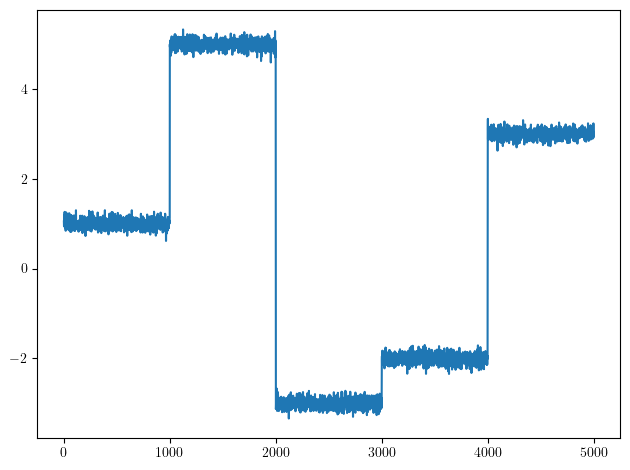

In [68]:
import numpy as np
import scipy.linalg as la
import scipy as sp
import matplotlib.pyplot as plt

n = 5000
EPSILON = 0.001
LAMBDA = 50
y = np.hstack([np.ones(1000) + 0.1 * np.random.randn(1000), 5 * np.ones(1000) + 0.1 *np.random.randn(1000),
                   -3*np.ones(1000) + 0.1 *np.random.randn(1000), -2 * np.ones(1000) + 0.1 *np.random.randn(1000),
                  3 * np.ones(1000) + 0.1 *np.random.randn(1000)])
plt.plot(y)
plt.tight_layout()

Для визуализации также построим $y_{step}$ - незашумленные "ступеньки"

In [69]:
y_step = np.hstack([np.ones(1000), 5 * np.ones(1000), -3*np.ones(1000) , -2 * np.ones(1000), 3 * np.ones(1000)])

Данная задача является выпуклой. 

Первое слагаемое, $f_1(x)$ , очевидно, является выпуклым как квадрат второй нормы от аффинной функции от $x$.

Второе регуляризационное слагаемое $g(x)$ является также выпуклой функцией. Она состоит из слагаемых вида:

 $h(x_i,x_{i+1}) = \sqrt{\varepsilon^2 + (x_{i+1} - x_i)^2} - \varepsilon$ (pseudo-huber). Функция $h(z) = \sqrt{\varepsilon^2 + z^2}$ - выпукла, так как $h''(z)=\frac{\varepsilon^2}{(\varepsilon^2+z^2)^{3/2}} \geq 0$, $z_i = x_{i+1} - x_i$ - линейное преобразование. Легко можно увидеть, что сумма также будет выпуклой функцией. Таким образом, оптимизируемая функция является выпуклой функцией от $x$.

Найдем градиент функции $f(x) = f_1(x) + g(x)$ (реализация в `grad_f`):

$\begin{aligned}
f_1(x) &= \|x - y \|_2^2;\\
\nabla f_1(x) &= 2(x-y)
\end{aligned}$

$\begin{aligned}
g(x) &= \lambda \sum_{i=0}^{n-1} \left(\sqrt{\varepsilon^2 + (x_{i+1} - x_i)^2} - \varepsilon\right);\\
\frac{\partial g(x)}{\partial x_i} &= 
\begin{cases} 
\dfrac{x_i - x_{i-1}}{\sqrt{\varepsilon^2 + (x_i - x_{i-1})^2}} - \dfrac{x_{i+1} - x_{i}}{\sqrt{\varepsilon^2 + (x_{i+1} - x_{i})^2}},\;&i\in [1;n-1];\\
-\dfrac{x_1 - x_0}{\sqrt{\varepsilon^2 + (x_1 - x_0)^2}},\;&i=0;\\
\dfrac{x_{n} - x_{n-1}}{\sqrt{\varepsilon^2 + (x_n - x_{n-1})^2}},\;&i=n.
\end{cases}
\end{aligned}$

$
\nabla f(x) = \nabla f_1(x) + \nabla g(x)
$

* Для начала решим задачу с использованием библиотеки `cvxpy`

In [70]:
import cvxpy as cp

x_cp = cp.Variable(n)
x_diff_cp = x_cp[1:] - x_cp[:-1]

f_1_cp = cp.sum_squares(x_cp - y)

g_cp = LAMBDA * (cp.sum(cp.norm(cp.vstack([EPSILON * np.ones(n-1), x_diff_cp]), axis=0)) - n * EPSILON)

f = f_1_cp + g_cp

objective = cp.Minimize(f)
problem = cp.Problem(objective)

_ = problem.solve(solver=cp.CLARABEL, verbose=True)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 30 04:16:50 PM: Your problem has 5000 variables, 0 constraints, and 0 parameters.
(CVXPY) Nov 30 04:16:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 30 04:16:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 30 04:16:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 30 04:16:50 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 30 04:16:50 PM: Compiling problem (target solver=CLARABEL)

Можем видеть, что алгоритм сошелся: зазор двойственности (`gap`) устремился к нулю. 

* Решим задачу также при помощи `sp.optimize.minimize`. начальной точкой здесь и ниже выберем $x_0=y$.

In [71]:
import numba
import functools

@numba.njit
def loss_f(x: np.ndarray, y: np.ndarray, lambd: float, eps: float) -> float:
    fisrt = np.sum((x - y)**2)
    second = lambd * np.sum(np.sqrt(eps**2 + (x[1:] - x[:-1])**2) - eps)
    return fisrt + second

@numba.njit
def grad_f(x: np.ndarray, y: np.ndarray, lambd: float, eps: float) -> np.ndarray:
    g = 2 * (x - y)
    diff_x = x[1:] - x[:-1]
    term = lambd * diff_x / np.sqrt(eps**2 + diff_x**2)
    g[:-1] -= term
    g[1:] += term
    return g
    
class CallbackSP:
    def __init__(self):
        self.log_x = []
        
    def __call__(self, intermediate_result):
        self.log_x.append(intermediate_result.x.copy())
        
    def report_grad_norm_loss(self, y, LAMBDA, EPSILON):
        log_x = np.array(self.log_x)
        grad_norm = np.apply_along_axis(func1d=lambda x: la.norm(grad_f(x, y, LAMBDA, EPSILON)), arr=log_x, axis=-1)
        loss = np.apply_along_axis(func1d=lambda x: loss_f(x, y, LAMBDA, EPSILON), arr=log_x, axis=-1)
        
        return grad_norm, loss

In [72]:
def plot_grad_norm_and_loss(
        grad_norm_loss_dict: dict[str, tuple[list, list]],
        title: str = "",
        loglog_grad_norm: bool = False,
        loglog_loss: bool = True,
    ) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title)
    
    for k, (name, (grad_norm, loss)) in enumerate(grad_norm_loss_dict.items()):
        name = name + f" [it: {len(grad_norm):g}]"
        if loglog_grad_norm:
            ax[0].loglog(grad_norm, label=name, color=f'C{k}')
            ax[0].scatter(len(grad_norm), grad_norm[-1], color=f'C{k}', edgecolor='black', marker='*', s=100, zorder=10)
        else:
            ax[0].semilogy(grad_norm, label=name, color=f'C{k}')
            ax[0].scatter(len(grad_norm), grad_norm[-1], color=f'C{k}', edgecolor='black', marker='*', s=100, zorder=10)
            
        if loglog_loss:
            ax[1].loglog(loss, label=name, color=f'C{k}')
            ax[1].scatter(len(loss), loss[-1], color=f'C{k}', edgecolor='black', marker='*', s=100, zorder=10)
        else:
            ax[1].semilogy(loss, label=name, color=f'C{k}')
            ax[1].scatter(len(loss), loss[-1], color=f'C{k}', edgecolor='black', marker='*', s=100, zorder=10)
        
        
    ax[0].legend()
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Gradient norm')
    ax[0].minorticks_on()
    ax[0].grid(True, which='major'); ax[0].grid(True, which='minor', lw=0.3, alpha=0.5)
    
    ax[1].legend()
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Loss')
    ax[1].minorticks_on()
    ax[1].grid(True, which='major'); plt.grid(True, which='minor', lw=0.3, alpha=0.5)

    fig.tight_layout()
    
def plot_x_star_y(x_star_dict, y, y_step, title=""):
    plt.figure(dpi=150)
    plt.plot(y, label="$y$", lw=0.4)
    plt.plot(y_step, label="$y_{step}$", lw=0.8, ls='--')
    for name, x_star in x_star_dict.items():
        plt.plot(x_star, label=f"$x^*$ [{name}]", lw=1.)
    plt.xlabel('i')
    plt.minorticks_on()
    plt.grid(True, which='major'); plt.grid(True, which='minor', lw=0.3, alpha=0.5)
    plt.legend()
    plt.title(title)
    plt.tight_layout()

In [73]:
# Solve the problem
callback_sp = CallbackSP()
sp_result = sp.optimize.minimize(
    fun=loss_f, 
    jac=grad_f, 
    x0=y, 
    args=(y, LAMBDA, EPSILON), 
    method='L-BFGS-B',
    callback=callback_sp
)

x_star_sp = sp_result.x
grad_norm_log_sp, loss_log_sp = callback_sp.report_grad_norm_loss(y, LAMBDA, EPSILON)

print("Solution x*:", x_star_sp)
print(f"loss(x*) = {loss_f(x_star_sp, y, LAMBDA, EPSILON)}")

Solution x*: [1.01346646 1.01346495 1.01346577 ... 3.01055885 3.01056555 3.01056328]
loss(x*) = 915.1433501740894


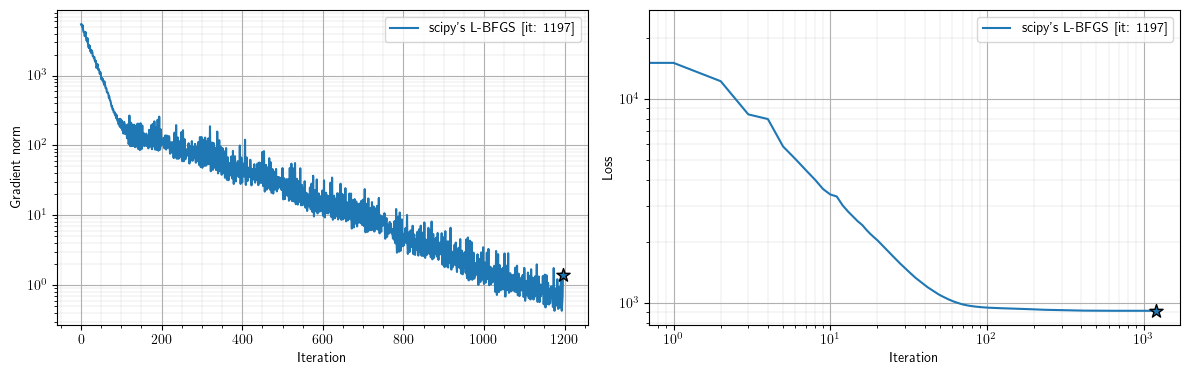

In [74]:
plot_grad_norm_and_loss({"scipy's L-BFGS" : (grad_norm_log_sp, loss_log_sp)}, title="")

Можем видеть, что вторая норма градиента уменьшаяется и выходит на некоторое плато в окрестности нуля в конце (с значительным уменьшением вариации нормы от шага к шагу). Это является знаком того, что алгоритм сошелся к оптимуму (при условии известной нам выпуклости задачи). Алгоритм сошелся за ~1200 итераций 

Здесь и ниже будем выберем условием останова вторую норму градиента из `sp.optimize.minimize` (L-BFGS) на момент окончания работы алгоритма оптимизации (`tol = tol_baseline`):

In [75]:
tol_baseline = la.norm(grad_f(sp_result.x, y, LAMBDA, EPSILON))
print(f"tol = {tol_baseline}")

tol = 1.391209666714724


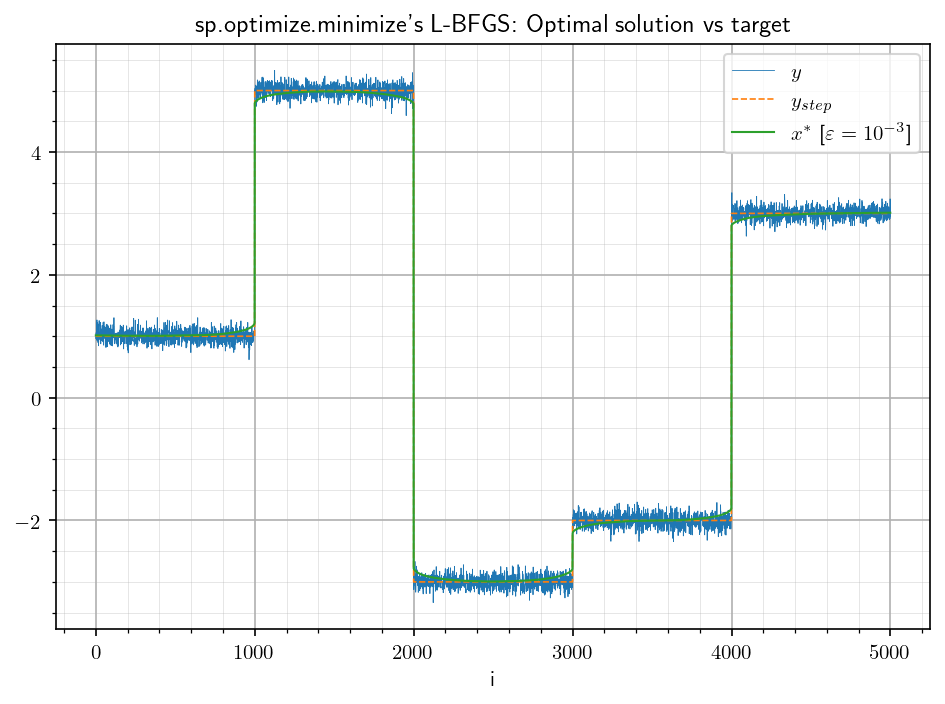

In [76]:
plot_x_star_y({r'$\varepsilon=10^{-3}$' : x_star_sp}, y, y_step, "sp.optimize.minimize's L-BFGS: Optimal solution vs target")

* **2 пункт**
    Рассотрим несколько алгоритмов оптимизации для данной задачи: 
    1) Градиентный спуск с несколькими фиксированными `lr`.
    2) Градиентный спуск с адаптивным шагом (в нем выбирается максимальная величина `lr`, на очередной интерации `lr` уменьшается в два раза в случае, если значение оптимизируемой функции увеличилось).
    3) Ускоренный градиентный метод с перезапусками. Для него подберем длину шага `lr` с помощью поиска по сетке.
    4) Метод L-BFGS.
    
    Условием останова для градиентных методов первого порядка, как было сказано выше, выберем ограничение сверху на норму градиента, полученного из L-BFGS в точке сходимости (`tol_baseline`). При этом заметим, что в реализации L-BFGS условия сходимости другие (относительное изменение значения функции), но для для сравнения между градиентными методами остановимся на это варианте.

In [77]:
def gd(
        grad: tp.Callable[[np.ndarray], np.ndarray],
        loss: tp.Callable[[np.ndarray], np.ndarray], 
        x_0: np.ndarray,
        lr: float,
        max_iter: int = 1_000_000, 
        tol: float = 0.,
    ) -> tuple[np.ndarray, list[float], list[float]]:
    loss_log = []
    grad_norm_log = []
    
    x = x_0.copy()
    
    for it in range(max_iter):
        g = grad(x)

        x -= lr * g
        
        loss_log.append(loss(x))
        grad_norm_log.append(np.linalg.norm(g))
        
        if grad_norm_log[-1] < tol:
            break

    return x, loss_log, grad_norm_log

def gd_adaptive_lr(
        grad: tp.Callable[[np.ndarray], np.ndarray],
        loss: tp.Callable[[np.ndarray], np.ndarray], 
        x_0: np.ndarray,
        lr: float,
        max_iter: int = 1_000_000, 
        tol: float = 0.,
    ) -> tuple[np.ndarray, list[float], list[float]]:
    loss_log = []
    grad_norm_log = []
    
    lr_init = lr
    x = x_0.copy()
    
    for it in range(max_iter):
        g = grad(x)
        lr = lr_init
        
        while True:
            x_new = x - lr * g
            if loss(x_new) < loss(x):
                x = x_new
                break
            else:
                lr /= 2
                if lr < 1e-16:
                    break
                
        if lr < 1e-16:
            break
        
        loss_log.append(loss(x))
        grad_norm_log.append(np.linalg.norm(g))
        
        if grad_norm_log[-1] < tol:
            break

    return x, loss_log, grad_norm_log

def accelerated_gd(
    grad: tp.Callable[[np.ndarray], np.ndarray],
    loss: tp.Callable[[np.ndarray], np.ndarray], 
    x_0: np.ndarray, 
    lr: float,
    restart: bool = False,
    max_iter: int = 1000, 
    tol: float = 0., 
) -> tuple[np.ndarray, list[float], list[float]]:
    
    loss_log = []
    grad_log = []
    
    x = x_0.copy()
    y = x_0.copy()
    
    k = 1
    for it in range(max_iter):
        x_next = y - lr * grad(y)
        
        # restart (if used)
        if restart and loss(x) < loss(x_next):
            x_next = x - lr * grad(x)
            k = 1
    
        y = x_next + k / (k + 3) * (x_next - x)
        x = x_next.copy()
        
        k += 1
        
        g = grad(x)
        loss_log.append(loss(x))
        grad_log.append(la.norm(g))
        
        if grad_log[-1] < tol:
            break
        
    return x, loss_log, grad_log

## cannot compete with scipy), 
## works good for simple tasks
# def bfgs(
#     grad,
#     loss,
#     x_0,
#     max_iter=1000,
#     tol=1e-8
# ):  
#     N = len(x_0)
#     H_k = np.eye(N)
#     x_k = x_0.copy()
#     g_k = grad(x_k)
    
#     for k in range(max_iter):
#         h_k = - H_k @ g_k
        
#         alpha_k = sp.optimize.line_search(loss, grad, x_k, h_k)[0]
        
#         x_k_1 = x_k + alpha_k * h_k
        
#         s_k = x_k_1 - x_k
        
#         g_k_1 = grad(x_k_1)
        
#         y_k = g_k_1 - g_k
        
#         rho_k = 1./(y_k @ s_k)
#         H_k_1 = H_k - rho_k * (
#             np.einsum('i,j,jk->ik', s_k, y_k, H_k, optimize='optimal') + 
#             np.einsum('ij,j,k->ik', H_k, y_k, s_k, optimize='optimal') - 
#             rho_k * np.einsum('i,j,jk,k,l->il', s_k, y_k, H_k, y_k, s_k, optimize='optimal') -
#             np.outer(s_k, s_k))

#         x_k = x_k_1
#         g_k = g_k_1
#         H_k = H_k_1
        
#         if np.linalg.norm(g_k) < tol:
#             break
        
#     return x_k

In [78]:
# make gd version with only one variable parameter: lr
gd_lr = functools.partial(
    gd, 
    grad=lambda x: grad_f(x, y, LAMBDA, EPSILON),
    loss=lambda x: loss_f(x, y, LAMBDA, EPSILON),
    x_0=y,
    max_iter=1_000_000,
    tol=tol_baseline
)

In [79]:
# simple GD (lr = 1e-5)
x_star_gd_lr_1e_5, loss_log_gd_1e_5, grad_norm_log_gd_1e_5 = gd_lr(lr=1e-5)

In [ ]:
# %%timeit -n 1 -r 7
# gd_lr(lr=1e-5)

3.23 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
# simple GD (lr = 5e-6)
x_star_gd_lr_5e_6, loss_log_gd_5e_6, grad_norm_log_gd_5e_6 = gd_lr(lr=5e-6)

In [ ]:
# %%timeit -n 1 -r 7
# gd_lr(lr=5e-6)

7.75 s ± 1.11 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
# simple GD (lr = 1e-6)
x_star_gd_lr_1e_6, loss_log_gd_1e_6, grad_norm_log_gd_1e_6 = gd_lr(lr=1e-6)

In [ ]:
# %%timeit -n 1 -r 7
# gd_lr(lr=1e-6)

37.8 s ± 4.24 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
# GD with adaptive lr (lr <= 5e-5)
x_star_gd_lr_ad, loss_log_gd_lr_ad, grad_norm_log_gd_lr_ad = gd_adaptive_lr(
    grad=lambda x: grad_f(x, y, LAMBDA, EPSILON),
    loss=lambda x: loss_f(x, y, LAMBDA, EPSILON),
    x_0=y,
    lr=5e-5,
    max_iter=1_000_000,
    tol=tol_baseline
)

Размер шага для ускоренного метода найдем поиском по сетке в интервале `lr=1e-6..1e-5`, в котором метод сходится. При больших значениях метод не может попасть в оптимум из-за большой длины шага, при меньшем - не успевает сойтись за максимальное число шагов из-за чрезмерно малых шагов.
По графику зависимости числа итераций от длины шага `lr` виден явный минимум. Выберем полученное значение `lr` для последующего анализа. 

In [83]:
# Accelerated GD 
# Let's find the best lr using grid search

acc_gd_lr_series = np.linspace(1, 10, 21) * 1e-6

acc_gd_num_iter_lr_series = []
acc_gd_best_num_it = np.inf
acc_gd_best_lr = acc_gd_lr_series[0]

for curr_lr in acc_gd_lr_series:
    x_star_acc_gd, loss_log_acc_gd, grad_norm_log_acc_gd = accelerated_gd(
        grad=lambda x: grad_f(x, y, LAMBDA, EPSILON),
        loss=lambda x: loss_f(x, y, LAMBDA, EPSILON),
        x_0=y,
        lr=curr_lr,
        restart=True,
        max_iter=1_000_000,
        tol=tol_baseline
    )
    acc_gd_num_iter_lr_series.append(len(loss_log_acc_gd))
    if acc_gd_best_num_it > len(loss_log_acc_gd):
        acc_gd_best_num_it = len(loss_log_acc_gd)
        acc_gd_best_lr = curr_lr

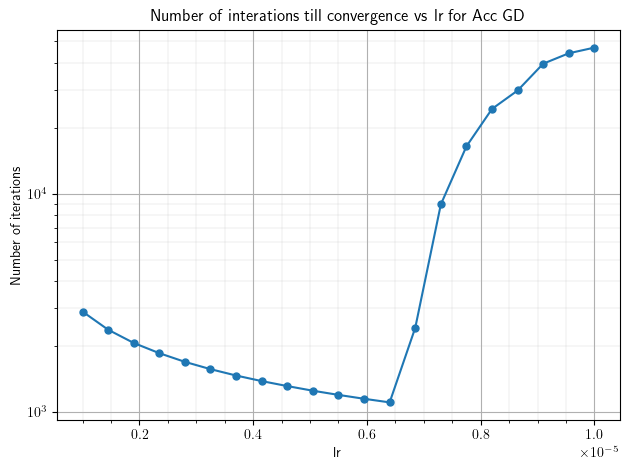

In [84]:
plt.figure()
plt.title("Number of interations till convergence vs lr for Acc GD")
plt.semilogy(acc_gd_lr_series, acc_gd_num_iter_lr_series, marker=".", ms=10)
plt.minorticks_on()
plt.grid(True, which='major'); plt.grid(True, which='minor', lw=0.3, alpha=0.5)
plt.xlabel('lr'); plt.ylabel('Number of iterations')
plt.tight_layout()

In [85]:
print(f"Best lr for Acc GD: {acc_gd_best_lr}")

Best lr for Acc GD: 6.4e-06


In [86]:
x_star_acc_gd, loss_log_acc_gd, grad_norm_log_acc_gd = accelerated_gd(
    grad=lambda x: grad_f(x, y, LAMBDA, EPSILON),
    loss=lambda x: loss_f(x, y, LAMBDA, EPSILON),
    x_0=y,
    lr=acc_gd_best_lr,
    restart=True,
    max_iter=1_000_000,
    tol=tol_baseline
)

In [ ]:
# %%timeit -n 1 -r 7
# accelerated_gd(
#     grad=lambda x: grad_f(x, y, LAMBDA, EPSILON),
#     loss=lambda x: loss_f(x, y, LAMBDA, EPSILON),
#     x_0=y,
#     lr=acc_gd_best_lr,
#     restart=True,
#     max_iter=1_000_000,
#     tol=tol_baseline
# )

133 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# let's compare nmse between gd x_star solutions and L-BFGS solution (compare also with cvxpy's solution): 
x_star_results = {   
    "GD (lr=1e-5)" : x_star_gd_lr_1e_5,
    "GD (lr=5e-6)" : x_star_gd_lr_5e_6,
    "GD (lr=1e-6)" : x_star_gd_lr_1e_6,
    "GD + adaptive lr" : x_star_gd_lr_ad,
    "Acc GD with restarts" : x_star_acc_gd,
    "cvxpy" : x_cp.value
}

for name, x_star_curr in x_star_results.items():
    print(f'{name:6}: error={np.linalg.norm(x_star_curr - x_star_sp) / np.linalg.norm(x_star_sp):.8f}')

GD (lr=1e-5): error=0.00286103
GD (lr=5e-6): error=0.00286106
GD (lr=1e-6): error=0.00286110
GD + adaptive lr: error=0.00253172
Acc GD with restarts: error=0.00134461
cvxpy : error=0.00008070


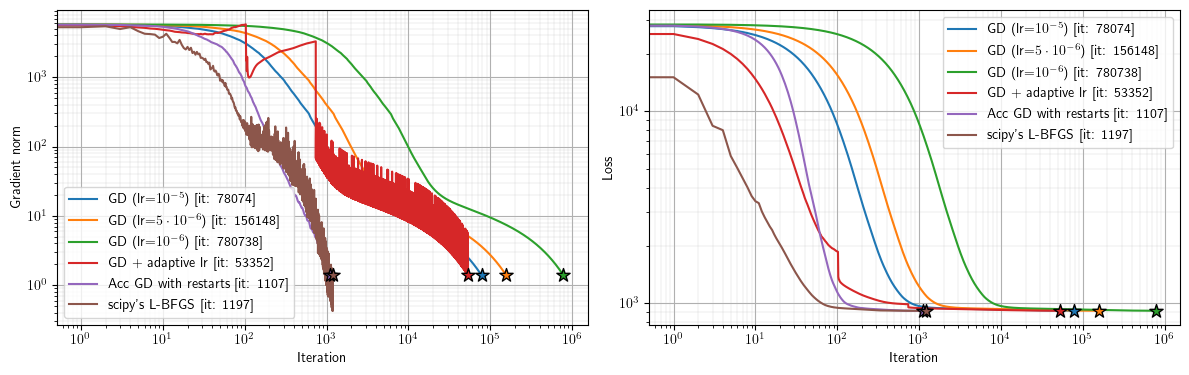

In [88]:
plot_grad_norm_and_loss(
    {   
        "GD (lr=$10^{-5}$)" : (grad_norm_log_gd_1e_5, loss_log_gd_1e_5),
        "GD (lr=$5 \\cdot 10^{-6}$)" : (grad_norm_log_gd_5e_6, loss_log_gd_5e_6),
        "GD (lr=$10^{-6}$)" : (grad_norm_log_gd_1e_6, loss_log_gd_1e_6),
        "GD + adaptive lr" : (grad_norm_log_gd_lr_ad, loss_log_gd_lr_ad),
        "Acc GD with restarts" : (grad_norm_log_acc_gd, loss_log_acc_gd),
        "scipy's L-BFGS" : (grad_norm_log_sp, loss_log_sp)
    }, 
    title="",
    loglog_grad_norm=True,
    loglog_loss=True
)

Из графиков сходимости можем сделать несколько выводов. При увеличиении значения `lr` от $10^{-5}$ до $10^{-6}$ скорость сходимости GD падает, требуется все больше шагов (и времени) для достижения оптимума. Адаптивный метод GD сходится за меньшее число итераций, чем методы с фиксированной длиной шага, однако по времени это занимает большее время, так как требуется пересчет значения функции и градиентов при подборе `lr`. L-BFGS и ускоренный градиентный методы показали схожие результаты, значительно опережающие остальные методы, как по числу итераций, так и по времени (при том что библиотечная реализация L-BFGS написана явно на высоком уровне). Эффективность ускоренного метода объясняется также тем, что для него был осуществен поиск оптимального `lr`, для других длин шага скорость сходимости метода значительно деградирует.

Все методы сошлись, оптимум $x^*$ для всех методов совпадает с хорошей точностью (по nmse ошибка не превышает 3e-3 относительно решения L-BFGS).

* **3 пункт**. В качестве оптимизатора воспользуемся ускоренным градиентным методом с перезапусками (`Acc GD`), так как он хорошо себя показал в сравнении с другими методами, в том числе имел сравнимый с L-BFGS результат по времени и числу итераций. Также проведем эксперимент и с L-BFGS из scipy. 

    Для ускоренного градиентного метода с $\varepsilon=10^{-3}$ оставим найденный оптимальный `lr=best_lr`. Для $\varepsilon=10^{-2}$ и $\varepsilon=10^{-4}$ будем исходить из следующего принципа. Оптимальным шагом градиентного спуска для L-гладкой функцией является `lr`=$1/L$. Будем считать, что найденный выше оптимальный `lr` для $\varepsilon=10^{-3}$ примерно оценивает данную величину. Заметим, что первое слагаемое (MSE) гладкая функция, имеет большую константу Липшица (2) и является сильно выпуклой (c константой 2), основной проблемой является регуляризационный член. Для функции Хьюбера известна оценка на константу Липшица, она может быть оценена сверху величиной $1/c$, где $c$ &mdash; граница перехода между MSE и MAE в функции.

    $\text{Huber}_c(x) = \dfrac{x^2}{2c} I\{|x| \leqslant c\} + \left(|x| - \dfrac{c}{2}\right)I\{|x| > c\}.$

    В данном задании используется гладкая версия функции Хьюбера, в которой $\varepsilon$ также регулирует величину константы Липшица функции, место гладкого перехода между MSE и MAE. Воспользуемсся следующей эвристикой: для других $\varepsilon \neq 10^{-3}$ выберем величину шага `lr` пропорциональной отношению между $10^{-3}$ и $\varepsilon$, то есть: `lr = best_lr * (eps/1e-3)`. Оказалось, что такой подход обеспечивает быструю сходимость гардиентного спуска для всех рассмотренных $\varepsilon$, совпадает с подобранными вручную для каждого $\varepsilon$ оптимальными длинами шага.

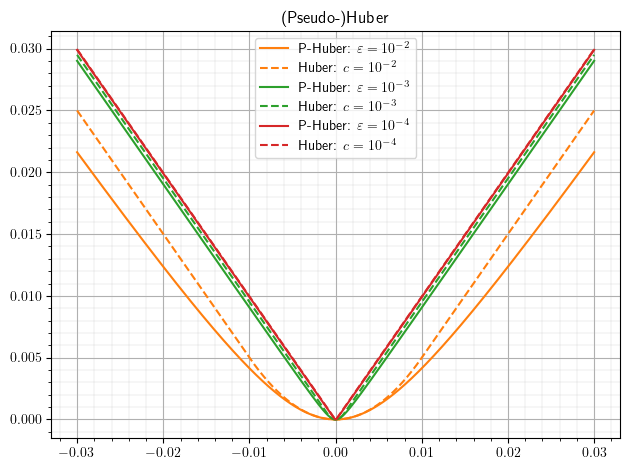

In [89]:
def pseudo_huber(x, eps):
    return np.sqrt(eps**2 + x**2) - eps

def huber(x, c):
    c_mask = (np.abs(x) <= c)
    return 0.5 * x**2 / c * c_mask + (np.abs(x) - 0.5 * c) * ~c_mask

plt.figure() 
plt.title('(Pseudo-)Huber')
xa = np.linspace(-0.03, 0.03, 10000)

plt.plot(xa, pseudo_huber(xa, 1e-2), label=r'P-Huber: $\varepsilon = 10^{-2}$', color='C1')
plt.plot(xa, huber(xa, 1e-2), label=r'Huber: $c = 10^{-2}$', color='C1', ls='--')

plt.plot(xa, pseudo_huber(xa, 1e-3), label=r'P-Huber: $\varepsilon = 10^{-3}$', color='C2')
plt.plot(xa, huber(xa, 1e-3), label=r'Huber: $c = 10^{-3}$', color='C2', ls='--')

plt.plot(xa, pseudo_huber(xa, 1e-4), label=r'P-Huber: $\varepsilon = 10^{-4}$', color='C3')
plt.plot(xa, huber(xa, 1e-4), label=r'Huber: $c = 10^{-4}$', color='C3', ls='--')

plt.minorticks_on()
plt.grid(True, which='major'); plt.grid(True, which='minor', lw=0.3, alpha=0.5)
plt.legend()
plt.tight_layout()

In [90]:
epsilon_series = [1e-2, 1e-3, 1e-4]
result_acc_gd_epsilon_series = {}
result_lbfgs_epsilon_series = {}

for eps in epsilon_series:
    
    lr_curr = acc_gd_best_lr * (eps/1e-3)
    
    result_acc_gd_epsilon_series[eps] = accelerated_gd(
        grad=lambda x: grad_f(x, y, LAMBDA, eps),
        loss=lambda x: loss_f(x, y, LAMBDA, eps),
        x_0=y,
        lr=lr_curr,
        max_iter=1_000_000,
        tol=tol_baseline
    )
    
    callback_sp = CallbackSP()
    sp_result = sp.optimize.minimize(
        fun=loss_f, 
        jac=grad_f, 
        x0=y, 
        args=(y, LAMBDA, eps), 
        method='L-BFGS-B',
        callback=callback_sp
    )
    result_lbfgs_epsilon_series[eps] = (sp_result.x, *callback_sp.report_grad_norm_loss(y, LAMBDA, EPSILON))

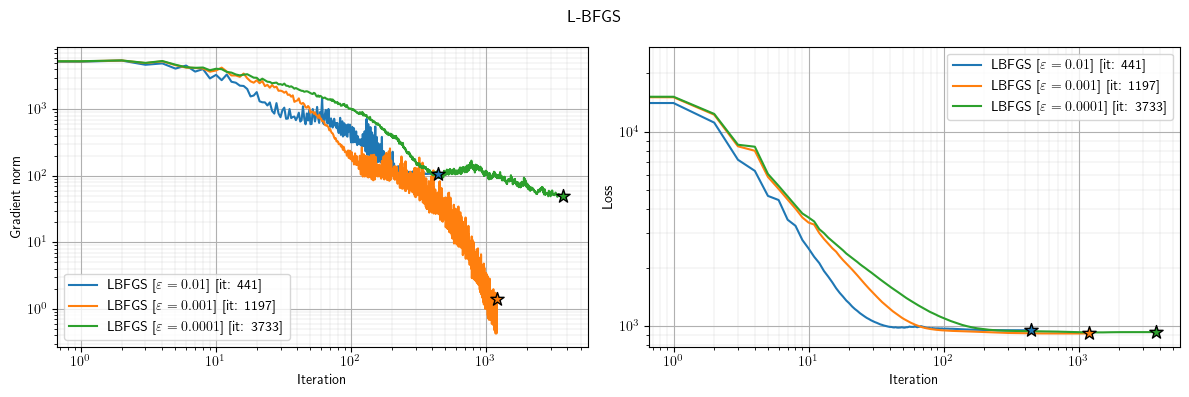

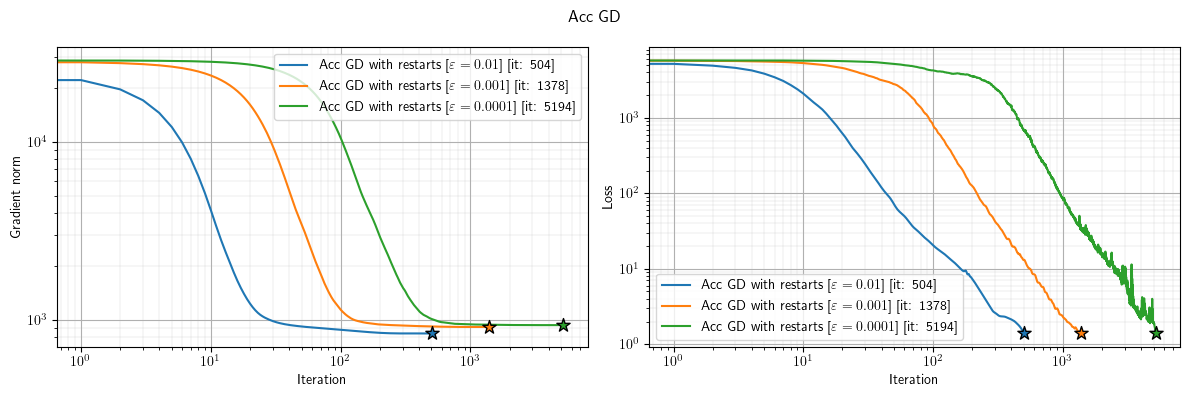

In [91]:
plot_grad_norm_and_loss(
    {   
        rf"LBFGS [$\varepsilon={eps}$]" : (result_lbfgs_epsilon_series[eps][1], result_lbfgs_epsilon_series[eps][2])
        for eps in epsilon_series
    }, 
    title="L-BFGS",
    loglog_grad_norm=True,
    loglog_loss=True
)
plot_grad_norm_and_loss(
    {   
        rf"Acc GD with restarts [$\varepsilon={eps}$]" : (result_acc_gd_epsilon_series[eps][1], result_acc_gd_epsilon_series[eps][2])
        for eps in epsilon_series
    }, 
    title="Acc GD",
    loglog_grad_norm=True,
    loglog_loss=True
)

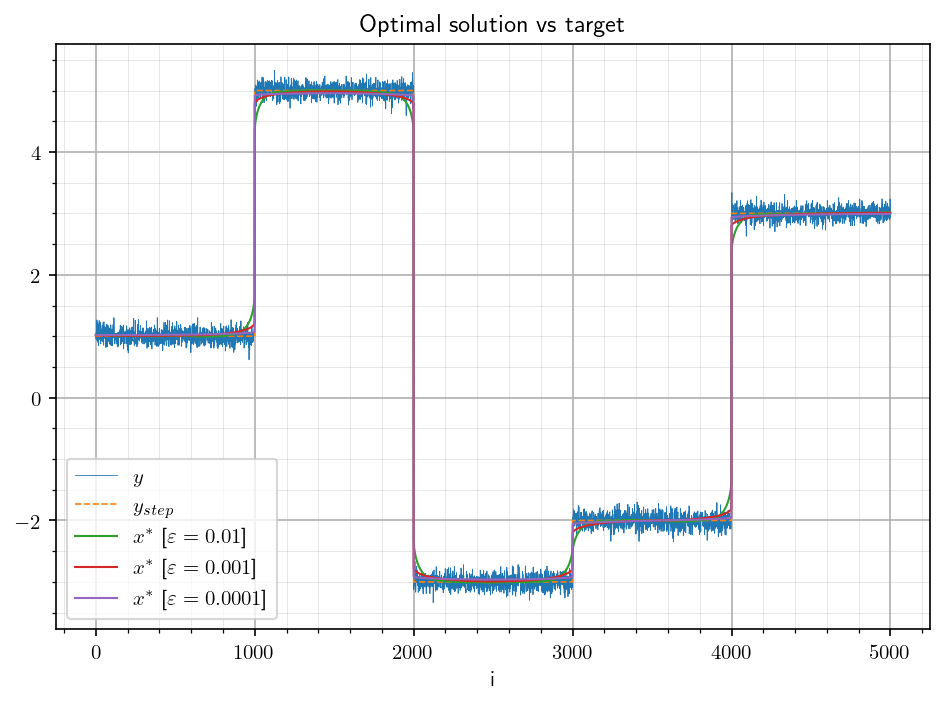

In [92]:
plot_x_star_y(
    {
        fr'$\varepsilon={eps}$' : result_lbfgs_epsilon_series[eps][0]
        for eps in epsilon_series
    },
    y, 
    y_step,
    "Optimal solution vs target"
)

Можем сделать некоторые выводы из полученных графиков. Увеличение $\varepsilon$ делает задачу более L-гладкой и сильно выпуклой, что увеличивает скорость сходимости градиентных методов. Из графиков сходимости можно видеть, что увеличение $\varepsilon$ на порядок приводит к увеличению в ~3 раза числа итераций, необходимых для сходимости (второе слагаемое все сильнее становится похоже на MAE).

 При изменении $\varepsilon$, естественно, изменяется оптимизируемая функция и решение задачи. Все решения "фильтруют" гауссов шум в сигнале, получаем сигнал $x^*$, близкий к исходным "ступенькам", но с некоторым смещением и сглаживанием на границах. В данной задаче функция Хьюбера "штрафует" изменение между соседними отсчетами, то есть значение этого регуляризационного члена растет при сильном изменении сигнала - в первую очередь, при наличии "ступеньки" (каждый тысячный отсчет). Эффект фильтрации также связан именно с этим слагаемым. Увеличение $\varepsilon$ уменьшает штраф на разницу между соседними отсчетами в окрестности нуля (см. графики pseuso-huber выше), при этом вдали от нуля функции с разными $\varepsilon$ в отностительных величинах почти не отличаются друг от друга. Поэтому оказывается более выгодным расширить область перехода между "ступеньками", даже ценой некоторого ухудшения величины основной части оптимизируемой функции, MSE, из-за дополнительного смещения. Так, при самом малом $\varepsilon=10^{-4}$ оказывается более оптимальным максимально уменьшить смещение на ступеньках и "оплатить" сильное изменение функции преимущественно на "ступеньке".

 Для интереса можно убрать MSE из оптимизируемой функции. Закономерно получим решение близкое к константе (нулевое изменение между соседними отсчетами), в данном случае к среднему значению сигнала (начальная точка, как и раньше, $y$). Если оставить только MSE, то решение полностью повторит исходный сигнал.

y_avg = 0.7993


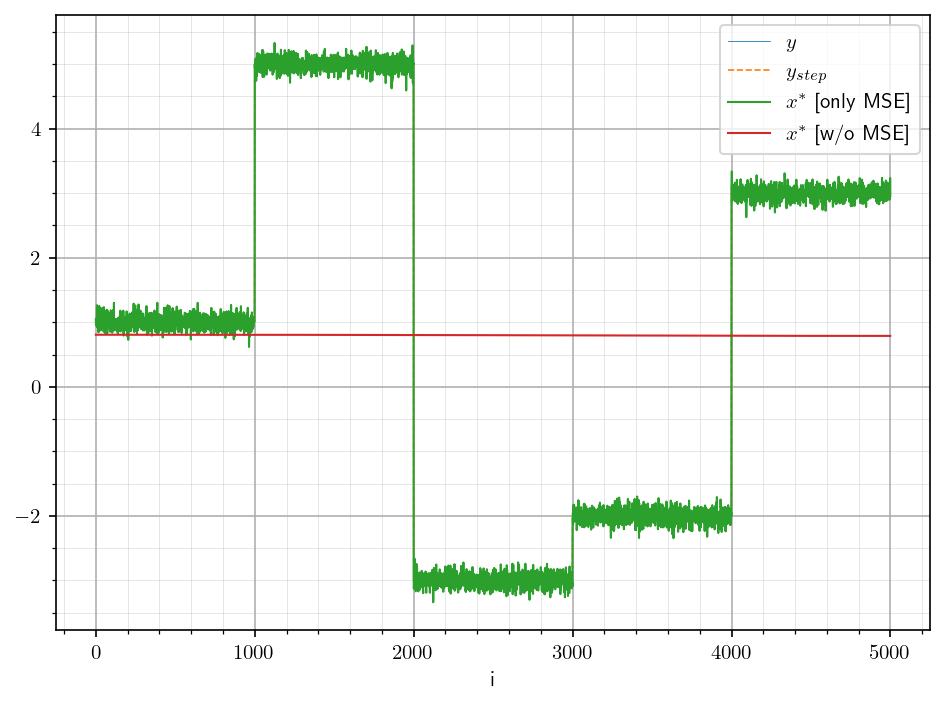

In [93]:
@numba.njit
def loss_f_wo_mse(x: np.ndarray, lambd: float, eps: float) -> float:
    return lambd * np.sum(np.sqrt(eps**2 + (x[1:] - x[:-1])**2) - eps)

@numba.njit
def grad_f_wo_mse(x: np.ndarray, lambd: float, eps: float) -> np.ndarray:
    g = np.zeros_like(x)
    diff_x = x[1:] - x[:-1]
    term = lambd * diff_x / np.sqrt(eps**2 + diff_x**2)
    g[:-1] -= term
    g[1:] += term
    return g

@numba.njit
def loss_f_mse(x: np.ndarray, y: np.ndarray) -> float:
    return np.sum((x - y)**2)

@numba.njit
def grad_f_mse(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return 2 * (x - y)

x_star_acc_gd_mse, _, _ = accelerated_gd(
    grad=lambda x: grad_f_mse(x, y),
    loss=lambda x: loss_f_mse(x, y),
    x_0=np.zeros_like(y),  # changed to 0
    lr=0.1,
    restart=True,
    max_iter=1_000_000,
    tol=1e-3
)

x_star_acc_gd_wo_mse, _, _ = accelerated_gd(
    grad=lambda x: grad_f_wo_mse(x, LAMBDA, 1e-2),
    loss=lambda x: loss_f_wo_mse(x, LAMBDA, 1e-2),
    x_0=y,
    lr=1e-5,
    restart=True,
    max_iter=1_000_000,
    tol=1e-3
)

print(f"y_avg = {y.mean():.4f}")
plot_x_star_y({ 'only MSE' : x_star_acc_gd_mse, 'w/o MSE' : x_star_acc_gd_wo_mse}, y, y_step)